In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torchvision.transforms as transforms

torch.manual_seed(55)

In [20]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.cn1 = nn.Conv2d(3, 6, 5)
        self.cn2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.cn1(x))
        x = F.max_pool2d(x, (2, 2))

        x = F.relu(self.cn2(x))
        x = F.max_pool2d(x, (2, 2))

        ## 단일 벡터로 평면화
        
        x = x.view(-1, self.flattened_features(x))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def flattened_features(self, x):

        ## 왜 첫번째 차원 제외?
        size = x.size()[1:]
        num_feats = 1 
        for s in size : 
            num_feats *= s 
        return num_feats 
    
lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [28]:
def train(net, trainloader, optim, epoch):
    loss_total = 0.0
    for i, data in enumerate(trainloader, 0):
        ip, ground_truth = data ## ip는 입력 이미지, ground truth는 출력 class
        optim.zero_grad()

        op = net(ip)

        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()

        optim.step()

        loss_total += loss.item()

        if (i+1) % 1000 == 0 : 
            print(\
                '[Epoch number : %d, Mini-batches: %5d] loss : %.3f'\
                    % (epoch+1, i+1, loss_total / 1000) \
                )
            loss_total = 0


In [8]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data 

            op = net(im)

            _, pred = torch.max(op.data, 1)

            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()
    
    print(\
        'LeNet accuracy on 10000 images from test dataset: %d %%'\
            % (100 * success / counter)\
        )

In [23]:
train_transform = transforms.Compose(\
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4), \
        transforms.ToTensor(),\
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))\
    ]\
)

trainset = torchvision.datasets.CIFAR10(
    root = './data', train=True, download=True, transform=train_transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size = 8, shuffle = True, num_workers=1
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(
    root = './data', train=False, download=True, transform=test_transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=10000, shuffle = False, num_workers=2
)

classes= ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


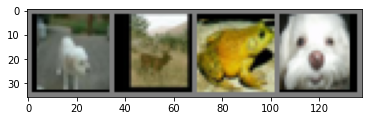

      dog      deer      frog      dog


In [22]:
def imageshow(image):
    image = image/2 + 0.5

    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
num_images=4
imageshow(torchvision.utils.make_grid(images[:num_images]))

print('      '+'      '.join(classes[labels[j]] for j in range(num_images)))

In [29]:
optim = torch.optim.Adam(lenet.parameters(), lr = 0.001)

for epoch in range(50):
    train(lenet, trainloader, optim, epoch)
    print()
    test(lenet, testloader)
    print()

print('Finished training')

[Epoch number : 1, Mini-batches:  1000] loss : 1.967
[Epoch number : 1, Mini-batches:  2000] loss : 1.725
[Epoch number : 1, Mini-batches:  3000] loss : 1.635
[Epoch number : 1, Mini-batches:  4000] loss : 1.585
[Epoch number : 1, Mini-batches:  5000] loss : 1.554
[Epoch number : 1, Mini-batches:  6000] loss : 1.510

LeNet accuracy on 10000 images from test dataset: 49 %

[Epoch number : 2, Mini-batches:  1000] loss : 1.462
[Epoch number : 2, Mini-batches:  2000] loss : 1.474
[Epoch number : 2, Mini-batches:  3000] loss : 1.428
[Epoch number : 2, Mini-batches:  4000] loss : 1.411
[Epoch number : 2, Mini-batches:  5000] loss : 1.420
[Epoch number : 2, Mini-batches:  6000] loss : 1.393

LeNet accuracy on 10000 images from test dataset: 53 %

[Epoch number : 3, Mini-batches:  1000] loss : 1.375
[Epoch number : 3, Mini-batches:  2000] loss : 1.358
[Epoch number : 3, Mini-batches:  3000] loss : 1.335
[Epoch number : 3, Mini-batches:  4000] loss : 1.331
[Epoch number : 3, Mini-batches:  5000

In [30]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

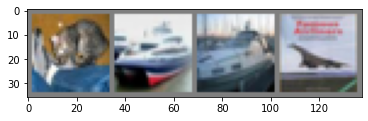

Label:       cat ship ship plane
Prediction:  cat car car plane


In [32]:
d_iter = iter(testloader)
im, ground_truth = next(d_iter)
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%s' % classes[ground_truth[j]] for j in range(4)))

lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

op = lenet_cached(im)

_, pred = torch.max(op, 1)
print('Prediction: ', ' '.join('%s' % classes[pred[j]] for j in range(4)))

In [33]:
class_success = list(0. for i in range(10))
class_counter = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()

        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_success[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1

for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (classes[i], 100 * class_success[i] / class_counter[i]))


Model accuracy for class plane : 74 %
Model accuracy for class   car : 87 %
Model accuracy for class  bird : 51 %
Model accuracy for class   cat : 48 %
Model accuracy for class  deer : 59 %
Model accuracy for class   dog : 62 %
Model accuracy for class  frog : 73 %
Model accuracy for class horse : 79 %
Model accuracy for class  ship : 63 %
Model accuracy for class truck : 72 %
